# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 0.001,          # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1, #1,      # Printing frequency.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Size of training set: 60000 samples
Size of test set: 10000 samples


# AutoEncoder Convolucional



![Convolutional AE](https://www.dropbox.com/s/mjiofz102bt4n5d/Conv_AE.png?dl=1)

# Atividade Prática: AutoEncoder Convolucional

Como mencionado previamente, um AE é uma arquitetura **Encoder-Decoder** com camadas de dimensionalidade simétrica. Vamos definir um AE Convolucional:

1.   Crie um Encoder composto por três blocos convolucionais (conv2d + ativação + maxpooling2d) que reduza gradativamente a dimensionalidade inicial dos dados ($28 \times 28$) para apenas $7 \times 7$ de resolução espacial no bottleneck. As convoluções devem ser pensadas para manter a dimensão dos dados, de forma que os feature maps só percam resolução espacial por meio do maxpooling2d com kernel size = 2 e stride = 2. A cada conv2d dobre o número de feature maps;
2.   Crie um Decoder com dois blocos de convolução transposta(conv2d + ativação + convtranspose2d) que recupere a resolução espacial dos dados. O último bloco do Decoder deve conter apenas uma conv2d seguida de ativação. A cada conv2d, divida o número de feature maps por 2. Visando preservar a simetria da arquitetura, ache uma combinação de parâmetros de forma que Convolução Transposta duplique a resolução espacial dos feature maps de entrada;
3.   Implemente o *forward()* passando os dados pelo Encoder e subsequentemente pelo Decoder;
4.   Defina a loss function (uma loss de regressão) e o otimizador;
5.   Complete as funções *train()* e *test()*.

PS. 1: as ativações de todas as camadas convolucionais devem ser ReLU, menos a última camada que deve ter como ativação uma função sigmóide.

PS. 2: usar kernel $3 \times 3$ e stride = 2 nas Convoluções Transpostas e a equação presente na [definição da função](https://pytorch.org/docs/stable/nn.html#convtranspose2d) para resolver os outros parâmetros e duplicar a resolução espacial.

# Definindo a arquitetura

In [4]:
# AutoEncoder implementation.
class ConvAutoEncoder(nn.Module):
    
    def __init__(self):

        super(ConvAutoEncoder, self).__init__()
        
        # TO DO: define encoder.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(2, 4, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(4, 8, kernel_size=(3, 3), stride=1, padding=1),
        )
        
        # TO DO: define decoder.
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(4, 2, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2, 2, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.Conv2d(2, 1, kernel_size=(3, 3), stride=1, padding=1),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.encoder(x)
        features = x
        x = self.decoder(x)
        return (x, features)
# Instantiating architecture.
net = ConvAutoEncoder().to(args['device'])

# Printing architecture.
print(net)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


# Definindo o otimizador

O Pytorch possui vários otimizadores prontos no subpacote [optim](https://pytorch.org/docs/stable/optim.html), desde o SGD básico a otimizadores mais complexos e com taxas de aprendizado por parâmetro como o Adagrad, RMSProp e Adam.

In [0]:
# TO DO: defining optimizer.
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(args['device'])

# Definindo a loss

A loss de um AE tradicional pode ser vista como uma loss de regressão, como o MSE ou a Loss L1.

In [0]:
# TO DO: defining regression loss.
criterion = nn.MSELoss().to(args['device'])

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # TO DO: Casting to cuda variables.
        inps = inps.to(args['device'])
        
        # TO DO: Clearing the gradients of optimizer.
        optimizer.zero_grad()

        # TO DO: Forwarding.
        outs, cods = net(inps)

        # TO DO: Computing loss.
        loss = criterion(outs, inps)

        # TO DO: Computing backpropagation.
        loss.backward()
        # TO DO: Taking step in optimizer.
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [0]:
# Testing procedure.
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])

        # Forwarding.
        outs, cods = net(inps)

        # Computing loss.
        loss = criterion(outs, inps)
        
        # Updating lists.
        test_loss.append(loss.data.item())
        
        # Plotting.
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(10, 8, figsize=(16, 20))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps[0, 0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs[0, 0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
            
            for c in range(cods.size(1)):
                
                ax[2 + c, i].imshow(cods[0, c].detach().cpu().numpy())
                ax[2 + c, i].set_yticks([])
                ax[2 + c, i].set_xticks([])
                ax[2 + c, i].set_title('Bottleneck[' + str(c) + '] ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train loss 0.0531 +/- 0.0451], [training time 19.89]
-------------------------------------------------------------------


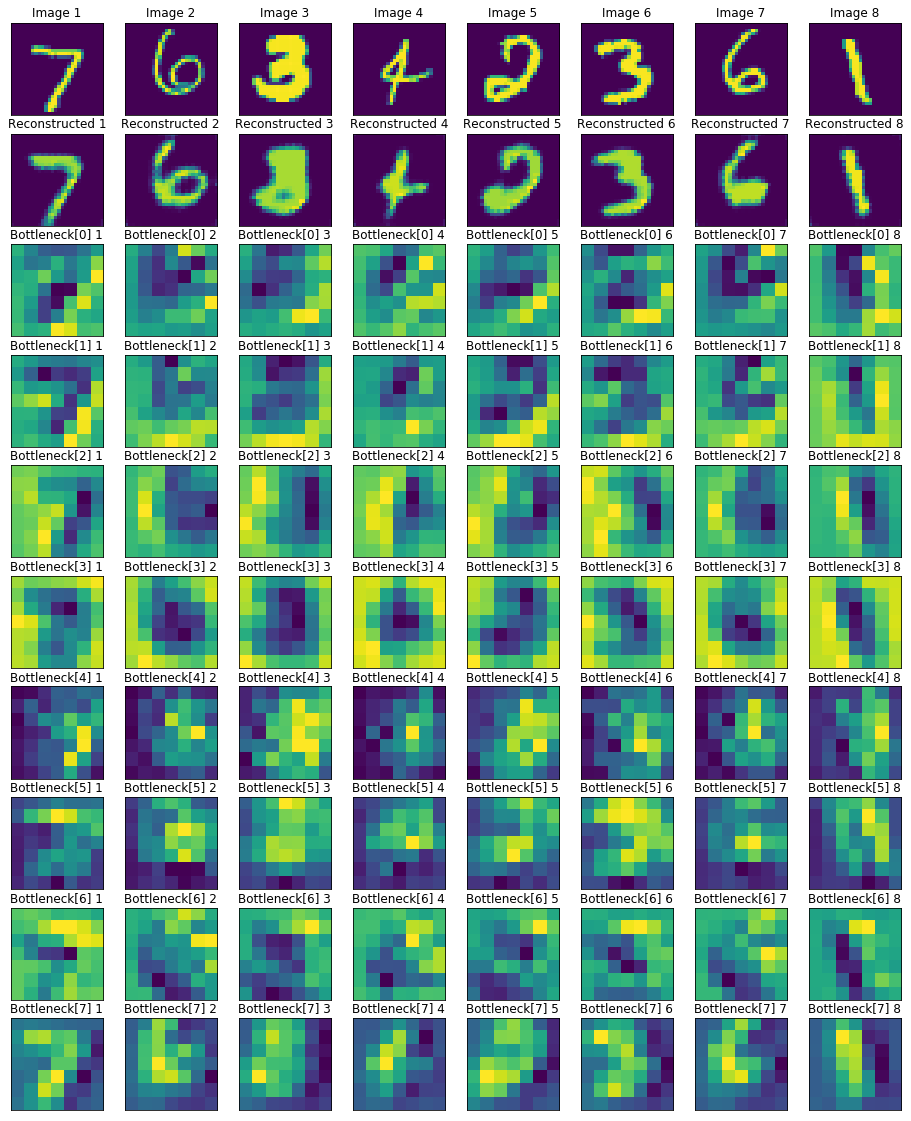

-------------------------------------------------------------------
[epoch 1], [test loss 0.0219 +/- 0.0013], [testing time 5.63]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.0163 +/- 0.0025], [training time 19.70]
-------------------------------------------------------------------


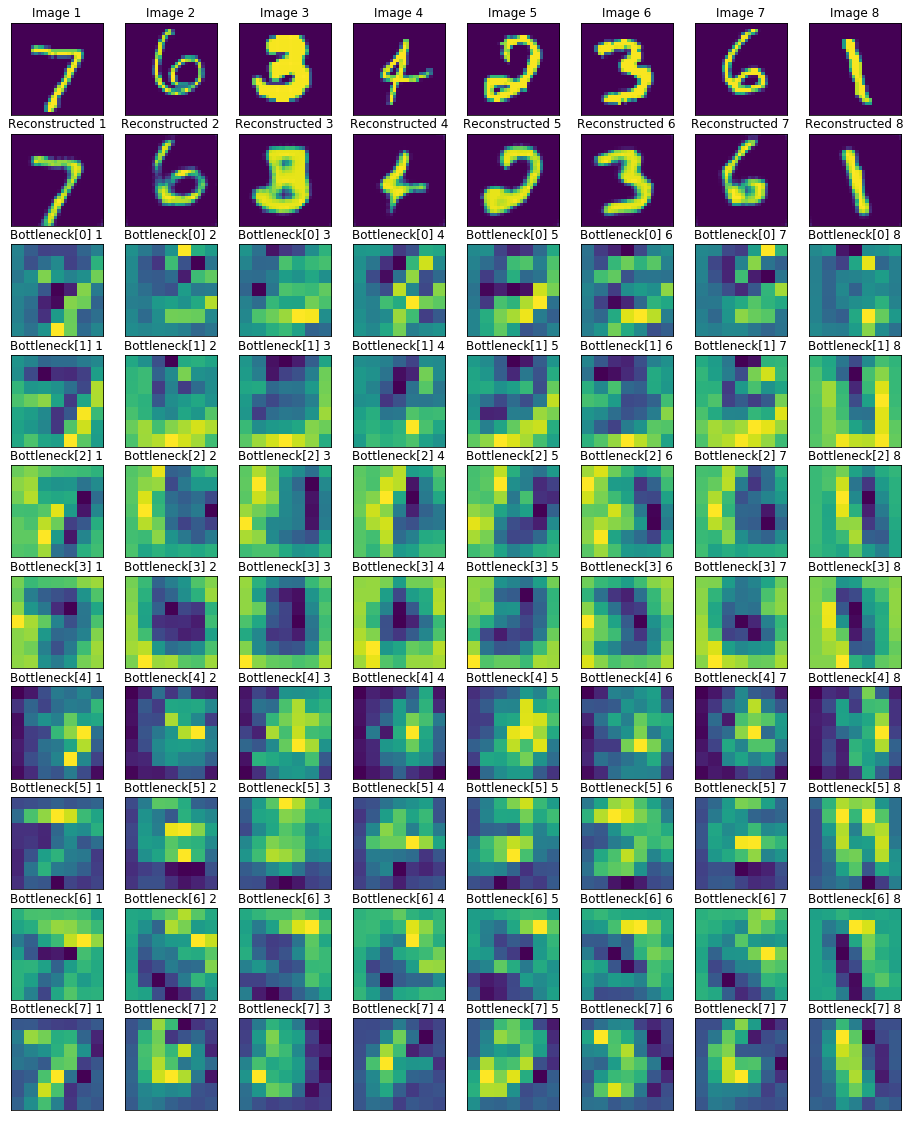

-------------------------------------------------------------------
[epoch 2], [test loss 0.0127 +/- 0.0008], [testing time 5.52]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train loss 0.0114 +/- 0.0009], [training time 19.42]
-------------------------------------------------------------------


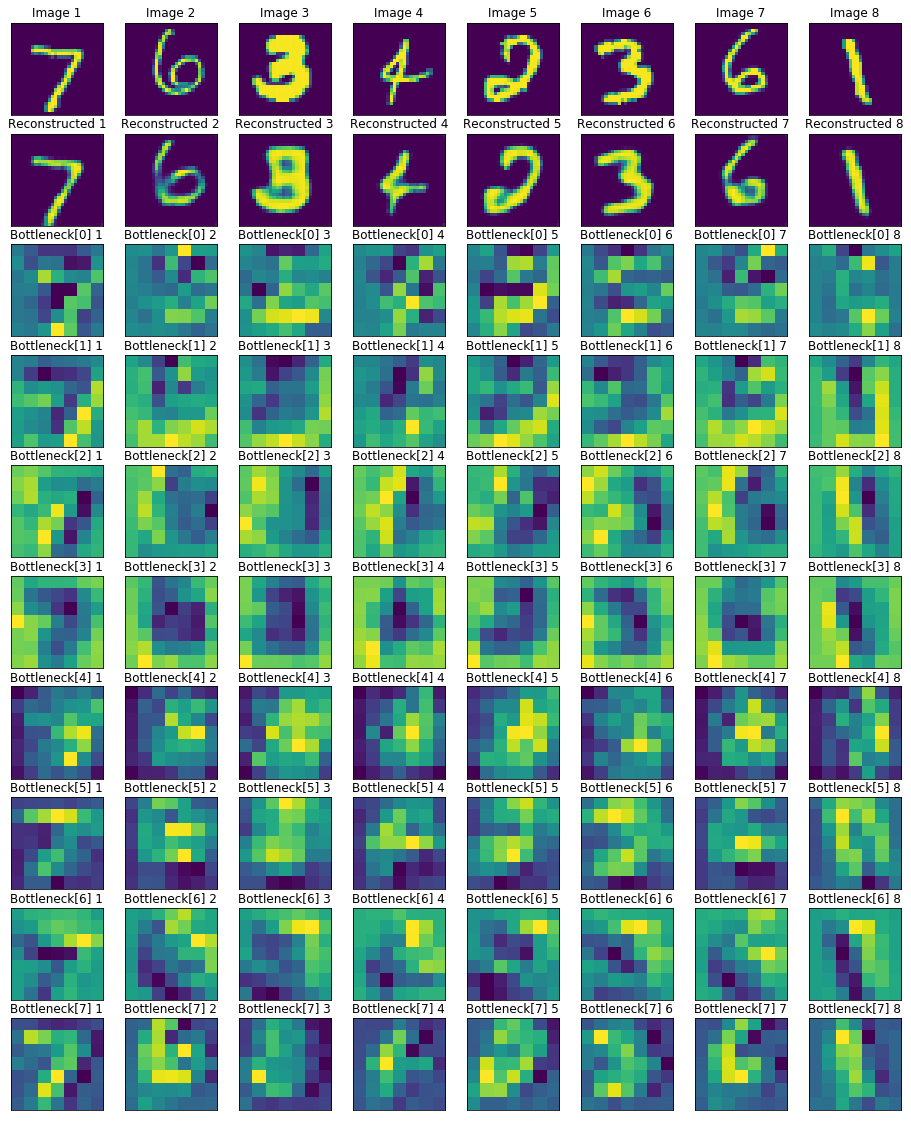

-------------------------------------------------------------------
[epoch 3], [test loss 0.0100 +/- 0.0007], [testing time 5.76]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train loss 0.0098 +/- 0.0005], [training time 19.73]
-------------------------------------------------------------------


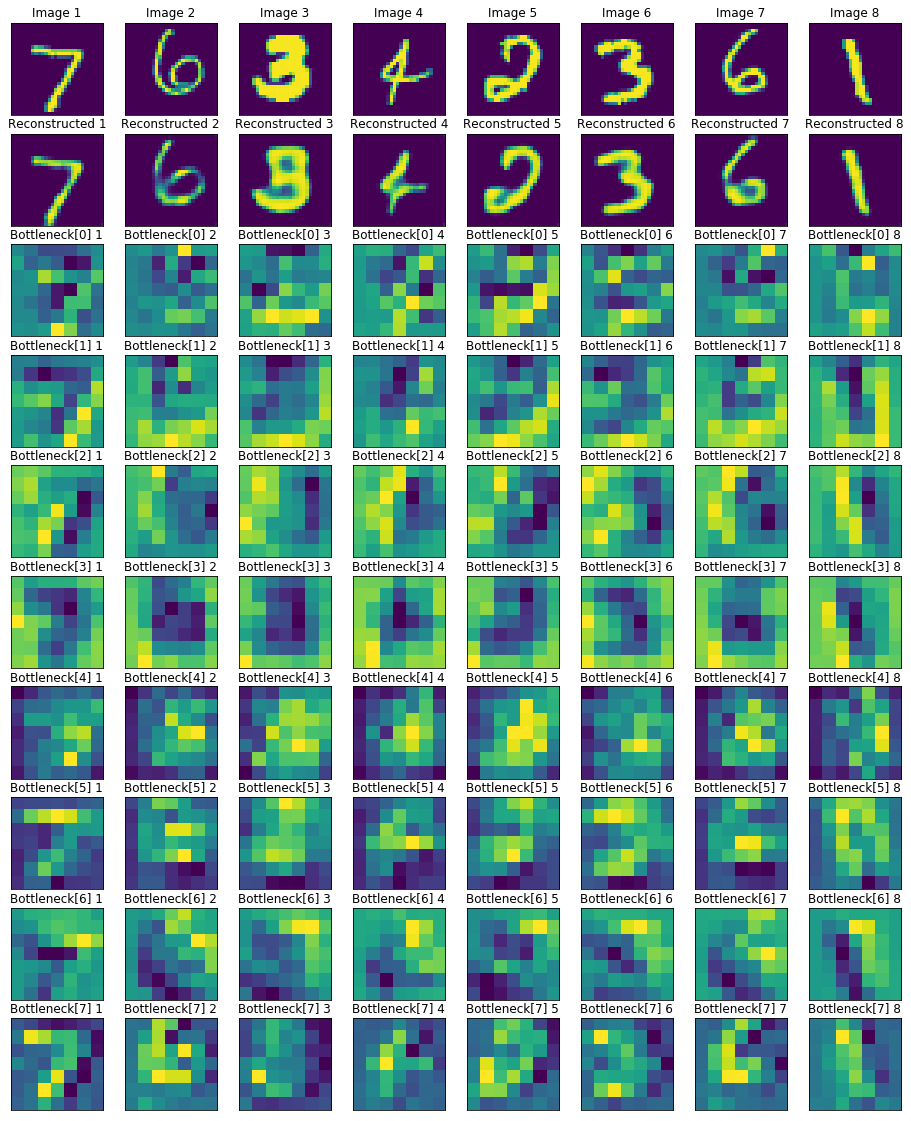

-------------------------------------------------------------------
[epoch 4], [test loss 0.0091 +/- 0.0007], [testing time 5.59]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train loss 0.0091 +/- 0.0005], [training time 19.75]
-------------------------------------------------------------------


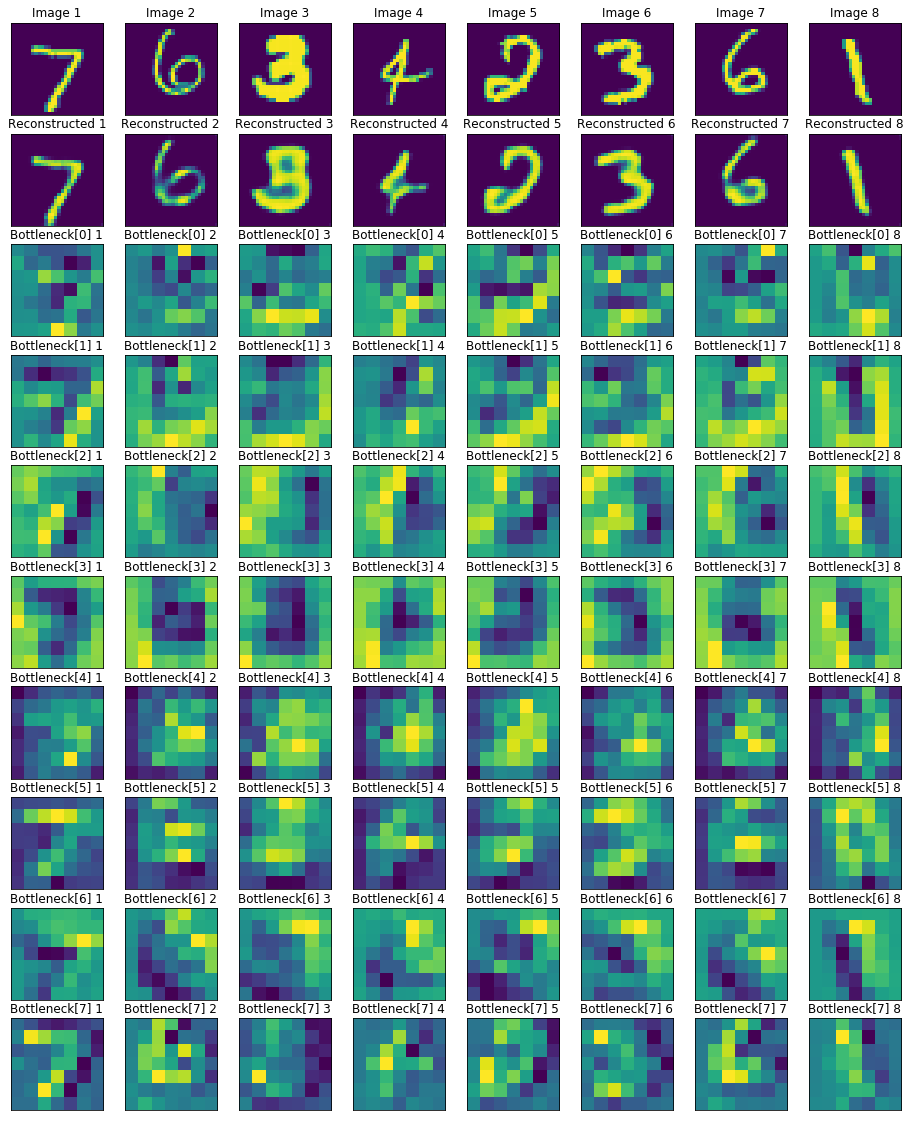

-------------------------------------------------------------------
[epoch 5], [test loss 0.0087 +/- 0.0006], [testing time 5.89]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train loss 0.0086 +/- 0.0004], [training time 20.03]
-------------------------------------------------------------------


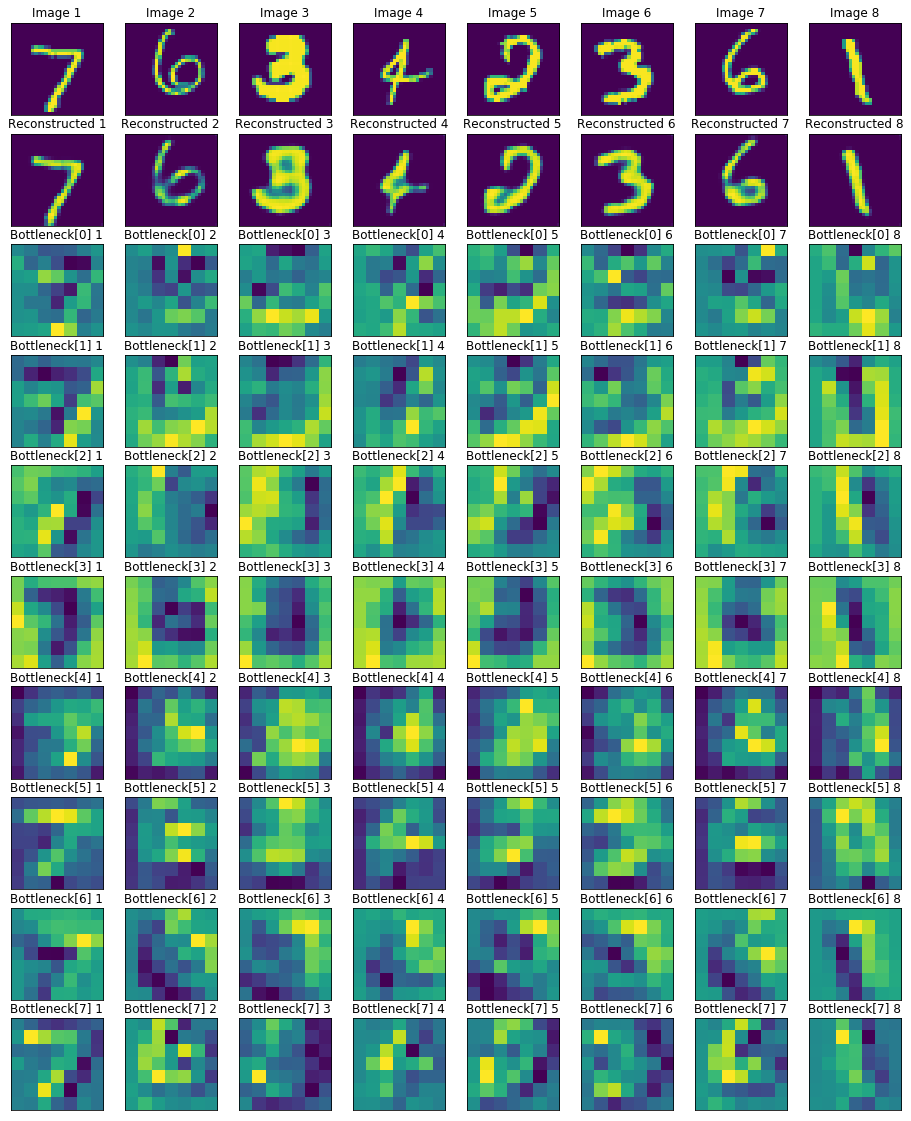

-------------------------------------------------------------------
[epoch 6], [test loss 0.0082 +/- 0.0006], [testing time 5.69]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train loss 0.0081 +/- 0.0004], [training time 19.61]
-------------------------------------------------------------------


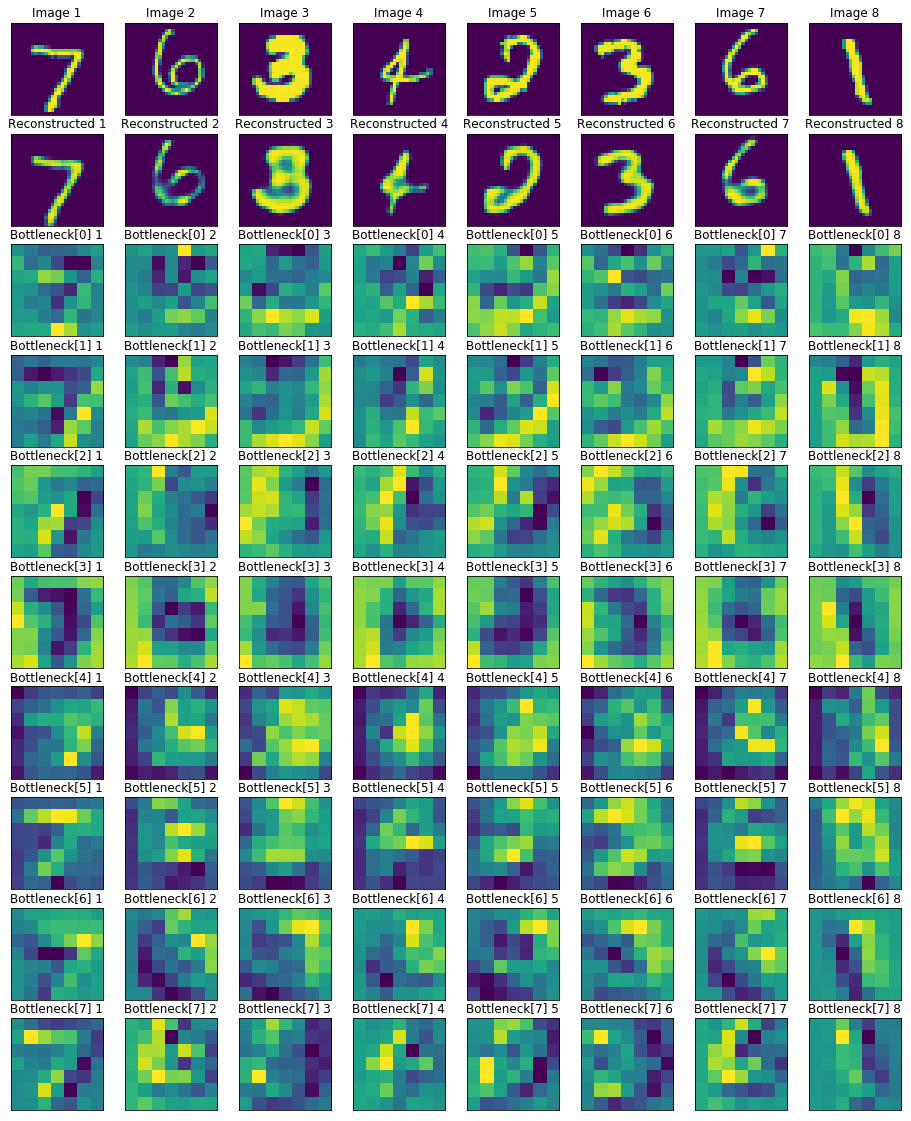

-------------------------------------------------------------------
[epoch 7], [test loss 0.0078 +/- 0.0006], [testing time 5.72]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train loss 0.0078 +/- 0.0004], [training time 19.86]
-------------------------------------------------------------------


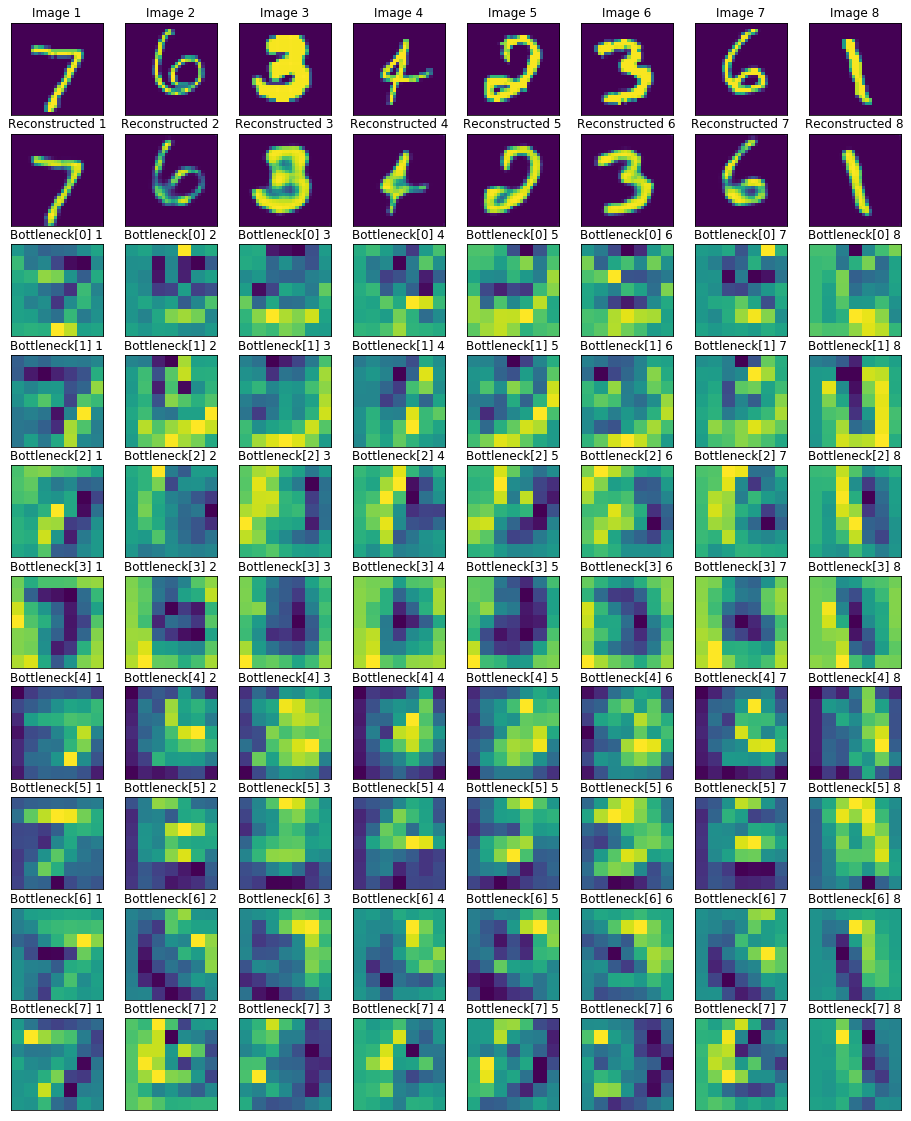

-------------------------------------------------------------------
[epoch 8], [test loss 0.0075 +/- 0.0006], [testing time 5.67]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train loss 0.0076 +/- 0.0004], [training time 19.53]
-------------------------------------------------------------------


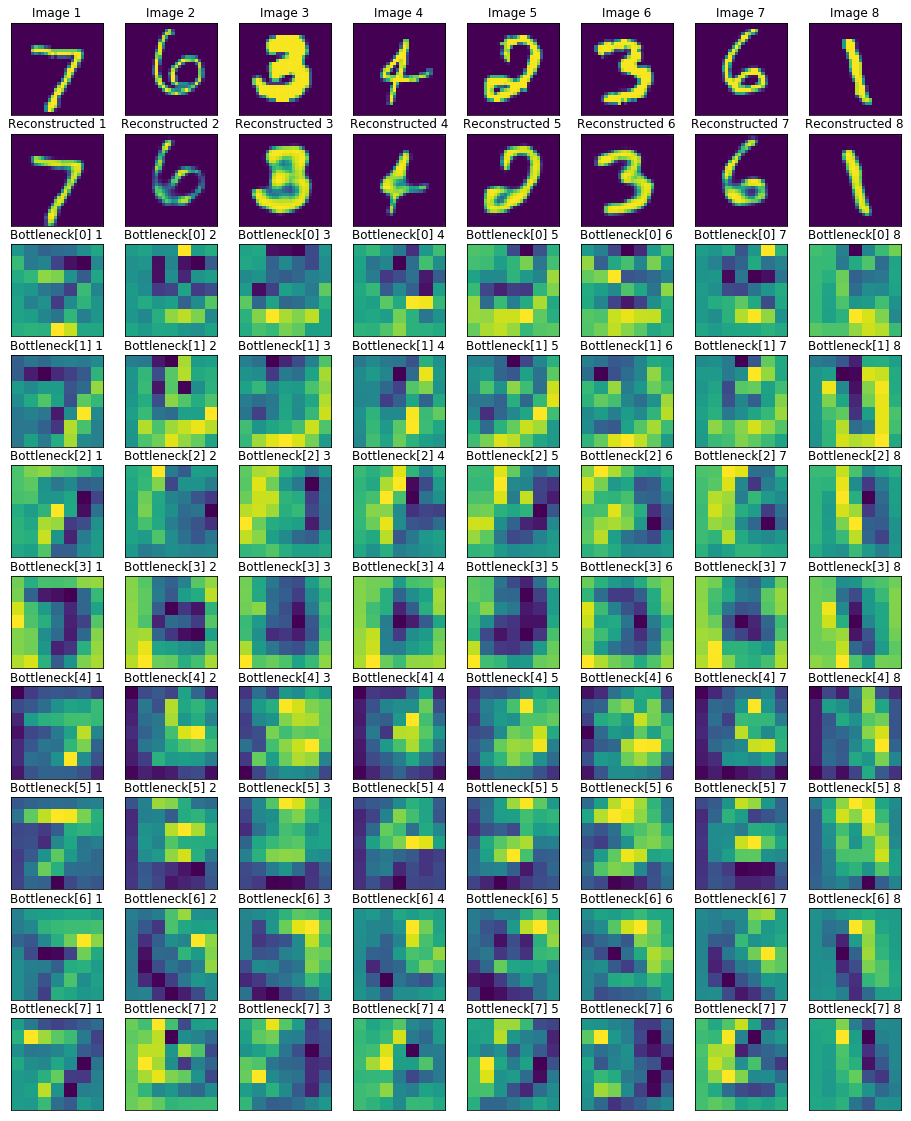

-------------------------------------------------------------------
[epoch 9], [test loss 0.0073 +/- 0.0006], [testing time 5.72]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train loss 0.0075 +/- 0.0004], [training time 19.66]
-------------------------------------------------------------------


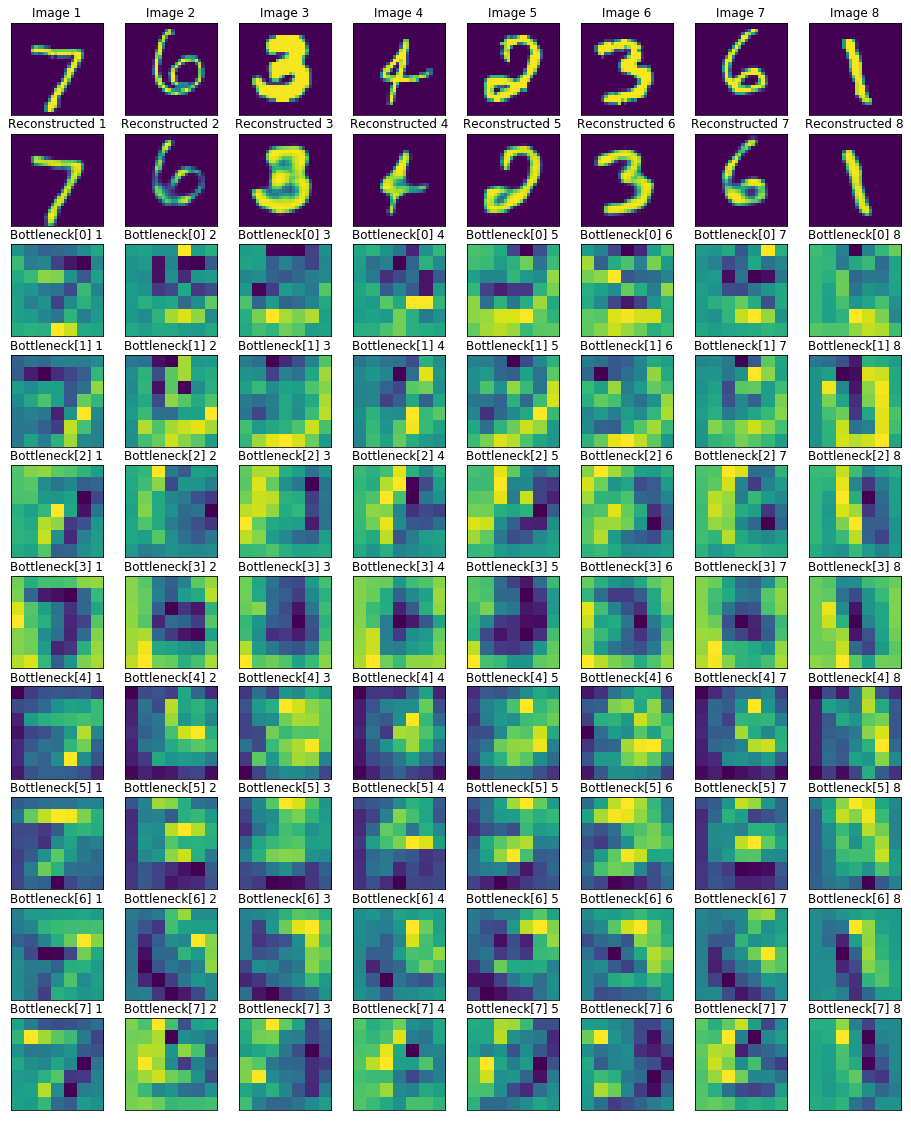

-------------------------------------------------------------------
[epoch 10], [test loss 0.0072 +/- 0.0006], [testing time 5.75]
-------------------------------------------------------------------


In [11]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

# Usando a representação de bottleneck como Deep Features

A camada de bottleneck de um AE Linear ou Convolucional pode ser linearizada e utilizada como **Deep Features** que podem servir de entrada para um algoritmo que vá realizar uma tarefa qualquer de Machine Learning (i.e. clusterização, regressão, classificação, etc). Dessa forma, o Encoder da rede passa a ser um extrator de **Deep Features** não-supervisionado.

![Conv AE Extractor](https://www.dropbox.com/s/11s5a5ynlu4g4wp/Conv_AE_Extractor.png?dl=1)

Nota-se que o Encoder foi otimizado para minimizar a reconstrução dos dados -- e não a classificação dos dígitos, no caso do MNIST -- conseguindo resultados de classificação que não podem ser equiparados aos modelos treinados de forma supervisionada end-to-end, porém ainda melhores que a maioria dos **Handcrafted Features**.

# Atividade Prática: Usando o Encoder como Extrator

Nessa atividade usaremos o Encoder do nosso AE Convolucional pré-treinado como extrator de features, passando os rótulos dos números como labels para o [Random Forest do sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Para isso, implemente os seguintes passos:

1.   Leia o conjunto de treino usando o *train_loader* pré-definido, faça o *forward* de cada batch sobre o encoder apenas, consiga a representação intermediária, linearize e salve amostra por amostra na lista *train_samples*. Os rótulos das imagens devem ser salvos (novamente amostra por amostra) na lista *train_labels*. Ambos features e rótulos devem ser transformados para arrays do numpy antes de serem salvos nas listas. Dica: usar função [*append()*](https://www.programiz.com/python-programming/methods/list/append) das listas do python;
2.   Faça o mesmo do passo 1., mas para o conjunto de teste e salvando nas listas *test_samples* e *test_labels*;
3.   Lembre-se de transformar as listas de features e labels para numpy usando a função [*np.asarray()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html);
4.   Instancie um Random Forest do sklearn de acordo com o link a cima;
5.   Treine o Random Forest com os features e labels do conjunto de treino do MNIST. Dica: método [*.fit(X_train, Y_train)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit);
6.   Teste a classificação nos features e labels do conjunto de testes do MNIST. Dica: método [*.predict(X_teste)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict);
7.   Calcule a [acurácia](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) do modelo para o conjunto de testes;
8.   Realize o mesmo procedimento para o AE Linear e compare os resultados com o AE Convolucional.

In [14]:
from sklearn import svm
from sklearn import ensemble
from sklearn import metrics

# Evaluating procedure for digit classification.
def evaluate(train_loader, test_loader, net):
    
    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for features and labels.
    train_samples = []
    train_labels = []
    
    test_samples = []
    test_labels = []
    
    ############################################################################
    # TO DO: Iterating over training batches. ##################################
    ############################################################################
    for i, batch_data in enumerate(train_loader):

        # TO DO: Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])

        # TO DO: Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            # TO DO: Using encodings cods[b] and cast them to cpu and numpy.
            features = cods[b].detach().cpu().numpy().flatten()
            
            # TO DO: Using labels labs[b].
            label = labs[b]
            
            # TO DO: Append lists with features and label of the current sample.
            train_samples.append(features)
            train_labels.append(label)

    ############################################################################
    # TO DO: Iterating over test batches. ######################################
    ############################################################################
    for i, batch_data in enumerate(test_loader):

        # TO DO: Obtaining images and labels for batch.
        inps, labs = batch_data

        # TO DO: Casting to cuda variables and reshaping.
        inps = inps.to(args['device'])

        # TO DO: Forwarding.
        outs, cods = net(inps)
        
        # Iterating over images in batch.
        for b in range(inps.size(0)):
            
            # TO DO: Using encodings cods[b] and cast them to cpu and numpy.
            features = cods[b].detach().cpu().numpy().flatten()
            
            # TO DO: Using labels labs[b].
            label = labs[b]
            
            # TO DO: Append lists with features and label of the current sample.
            test_samples.append(features)
            test_labels.append(label)
    
    # TO DO: Transforming lists to numpy arrays.
    train_samples = np.array(train_samples)
    train_labels = np.array(train_labels)
    
    test_samples = np.array(test_samples)
    test_labels = np.array(test_labels)
    
    
    # TO DO: Instantiating Random Forest.
    clf_rf = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10,
                                    random_state=42)
    
    # TO DO: Fitting training data.
    clf_rf.fit(train_samples,train_labels)
    
    # TO DO: Predicting test data.
    prediction = clf_rf.predict(test_samples)
    
    # TO DO: Computing accuracy.
    acc_rf = np.mean(test_labels == prediction)
    
    toc = time.time()
    
    # Using the features to perform classification on a supervised setting.
    print('-------------------------------------------------------------------')
    print('[rf accuracy %.4f], [time %.2f]' % (
        acc_rf, (toc - tic)))
    print('-------------------------------------------------------------------')
    
# Calling evaluation function.
evaluate(train_loader, test_loader, net)

-------------------------------------------------------------------
[rf accuracy 0.9373], [time 68.30]
-------------------------------------------------------------------
